In [4]:
import numpy as np 
import pandas as pd 

import os


In [35]:
import os
source_dir=os.path.join('/kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train')

In [36]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        
        # identity name
        self.name = name
        
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    c = 0
    for i in os.listdir(path):
        if c==300:
            break
        c+=1
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)


metadata = load_metadata(source_dir)
metadata

array([/kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train/n008215/0010_01.jpg,
       /kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train/n008215/0228_01.jpg,
       /kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train/n008215/0193_01.jpg,
       ...,
       /kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train/n003696/0555_02.jpg,
       /kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train/n003696/0003_01.jpg,
       /kaggle/input/11-785-s22-hw2p2-classification/classification/classification/train/n003696/0059_01.jpg],
      dtype=object)

In [37]:
print('metadata shape :', metadata.shape)

metadata shape : (6000,)


In [38]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # BGR to RGB
    return img[...,::-1]

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [40]:
model = vgg_face()

model.load_weights('../input/VGG-Face/vgg_face_weights.h5')

In [41]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [42]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_13_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten_1')>])

In [43]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [44]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 6000


In [45]:
from tqdm import tqdm,trange,tqdm_notebook
from time import sleep

In [46]:

embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in tqdm(enumerate(metadata)):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

6000it [09:45, 10.24it/s]


In [47]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (6000, 2622)


In [48]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [49]:
import matplotlib.pyplot as plt

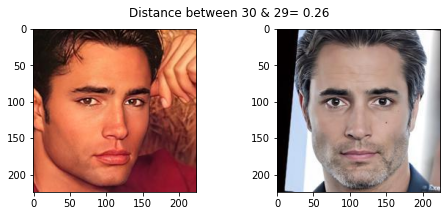

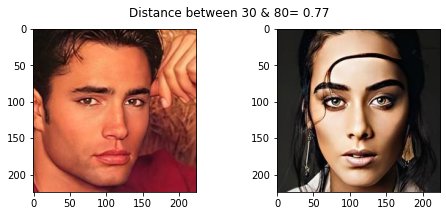

In [66]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(30, 29)
show_pair(30, 80)

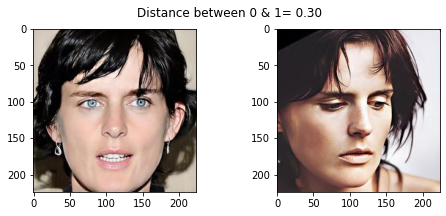

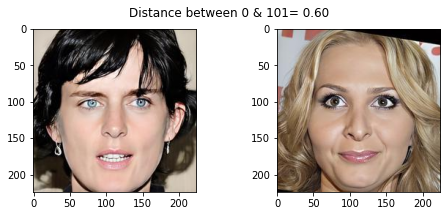

In [67]:
show_pair(0, 1)
show_pair(0, 101)

In [68]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0   
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [69]:
test_idx

array([ True, False, False, ..., False, False, False])

In [70]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (5333,2622)
y_train shape : (5333,)
X_test shape : (667,2622)
y_test shape : (667,)


In [71]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train_encoded

array([270, 270, 270, ..., 131, 131, 131])

In [72]:
print(le.classes_)
y_test_encoded = le.transform(y_test)
print(y_test_encoded)

['n000017' 'n000054' 'n000137' 'n000208' 'n000213' 'n000226' 'n000242'
 'n000286' 'n000319' 'n000346' 'n000453' 'n000463' 'n000512' 'n000564'
 'n000570' 'n000585' 'n000615' 'n000641' 'n000681' 'n000752' 'n000776'
 'n000790' 'n000816' 'n000822' 'n000855' 'n000891' 'n000896' 'n000942'
 'n000962' 'n000985' 'n000999' 'n001010' 'n001048' 'n001054' 'n001140'
 'n001149' 'n001158' 'n001184' 'n001230' 'n001255' 'n001278' 'n001350'
 'n001470' 'n001522' 'n001628' 'n001633' 'n001644' 'n001691' 'n001696'
 'n001715' 'n001720' 'n001748' 'n001758' 'n001773' 'n001801' 'n001840'
 'n001867' 'n001905' 'n001911' 'n001914' 'n001954' 'n001968' 'n001970'
 'n001984' 'n001990' 'n002017' 'n002041' 'n002046' 'n002161' 'n002175'
 'n002182' 'n002186' 'n002192' 'n002210' 'n002224' 'n002234' 'n002247'
 'n002292' 'n002327' 'n002354' 'n002393' 'n002419' 'n002428' 'n002433'
 'n002520' 'n002525' 'n002550' 'n002619' 'n002685' 'n002694' 'n002702'
 'n002727' 'n002736' 'n002751' 'n002802' 'n002811' 'n002817' 'n002822'
 'n002

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [74]:
X_test_std = scaler.transform(X_test)



In [75]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (5333,2622)
y_train_encoded shape : (5333,)
X_test_std shape : (667,2622)
y_test_encoded shape : (667,)


In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [102]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.0001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.0001)

In [103]:
y_predict = clf.predict(X_test_pca)


In [104]:
y_predict_encoded = le.inverse_transform(y_predict)


In [105]:
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
accuracy_score(y_test_encoded, y_predict)


0.8680659670164917

In [ ]:
y_predict

Test data ->


In [ ]:
test_dir=os.path.join('/kaggle/input/11-785-s22-hw2p2-classification/classification/classification/test')

In [ ]:
class IdentityTestdata():
    def __init__(self, base, file):
        self.base = base
        
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
    
def load_test_data(path):
    test_data = []

    for i in os.listdir(path):
        test_data.append(IdentityTestdata(path, i))
        
    return np.array(test_data)

test_data = load_test_data(test_dir)
test_data

In [ ]:

embeddings_test = np.zeros((test_data.shape[0], 2622))
for i, m in tqdm(enumerate(test_data)):
    img_path = test_data[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings_test[i]=embedding_vector
embeddings_test

In [ ]:
Final_test = scaler.transform(embeddings_test)
Final_test_pca = pca.fit_transform(Final_test)

In [ ]:
Final_predict = clf.predict(Final_test_pca)

In [ ]:
Final_value = le.inverse_transform(Final_predict)
Final_value

In [ ]:
Final_ans = [int(w[1:]) for w in Final_value ]
Final_ans

In [ ]:
df = pd.read_csv('../input/11-785-s22-hw2p2-classification/classification_sample_submission.csv')

In [ ]:
df

In [ ]:
df['label'] = Final_ans

In [ ]:
df

In [ ]:

df.to_csv("submission.csv",index=False)